<center>

# Analiza mreža
## Projekt - Uber Drives

### 2022./2023.
## Marijana Rendulić
</center>

**DATASET SOURCE:** https://www.kaggle.com/datasets/zusmani/uberdrives

**DATASET DESCRIPTION:** 
Skup podataka "My Uber Drives" sadrži informacije o putovanjima vozača Ubera tijekom 2016. godine. Skup podataka uključuje 1155 redaka i 7 stupaca, koji su:
- START_DATE: datum i vrijeme početka putovanja
- END_DATE: datum i vrijeme završetka putovanja
- CATEGORY: kategorija putovanja (Business, Personal)
- START: početna lokacija
- STOP: mjesto završetka
- MILES: udaljenost putovanja u miljama
- PURPOSE: svrha putovanja (Meal/Entertain, Errand/Supplies, Meeting, Customer Visit)

**INTENTION:** Razumijevanje obrazaca putovanja i čimbenika koji utječu na ponašanje pri putovanju korisnika Ubera

**HYPOTHESIS:** 
- Postoji glavno čvorište u mreži putovanja.
- Postoji razlika u vremenu putovanja između lokacija po milji.
- Poslovna putovanja imaju veće udaljenosti u usporedbi s osobnim putovanjima.
- Putovanja sa svrhom "Meeting" imaju veću prosječnu udaljenost od putovanja s drugim svrhama.
- Postoji razlog zbog kojega su baš određene lokacije slabije posjećene.
- Određene svrhe putovanja ističu se za pojedini čvor.

**PSEUDOKOD:**

- Install the required packages.
- Import necessary libraries.
- Mount Google Drive and load the CSV data into a DataFrame.
- Create a networkx Graph object.
- Add nodes to the graph for each unique location in the dataset.
- Add edges to the graph for each trip in the dataset.
- Perform basic network analysis.
- Create a random subgraph for further analysis.
- Visualize the subgraph.
- Calculate clustering coefficient, centrality measures, and community detection.
- Analyze communities and identify important nodes.
- Calculate and print the diameter of the graph and the largest connected component.

# Priprema podataka

Ovaj dio saržava učitavanje podataka, njihovu provjeru te korištene biblioteke u projektu.

##Biblioteke

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

**Pandas** je biblioteka za analizu podataka koja se koristi u Pythonu. Omogućuje strukture podataka za učinkovito pohranjivanje i rukovanje velikim skupovima podataka, kao i niz alata za analizu i čišćenje podataka.

**NetworkX** je Python paket za stvaranje, manipuliranje i proučavanje složenih mreža. Omogućuje alate za analizu mrežnih svojstava, kao što je središnji stupanj stupnja i središnji položaj između, te za vizualizaciju mreža.


**NumPy** je Python paket koji se koristi za znanstveno računalstvo. Omogućuje alate za rad s nizovima i matricama, kao i razne numeričke i statističke operacije.

**Seaborn** je Python biblioteka za vizualizaciju podataka temeljena na matplotlibu. Omogućuje sučelje više razine za stvaranje statističke grafike, kao što su toplinske karte i grafikoni violine.

**Matplotlib** je biblioteka za crtanje u Pythonu. Pyplot je podbiblioteka unutar Matplotliba koja pruža jednostavno sučelje za izradu grafikona i drugih vizualizacija.

**Collections** su ugrađeni Python modul koji pruža alternative ugrađenim Python strukturama podataka kao što su popisi i rječnici. Klasa brojača unutar modula je spremnik koji pohranjuje elemente kao ključeve rječnika, a njihovi brojevi se pohranjuju kao vrijednosti rječnika. Korisno je za brojanje pojavljivanja elemenata u nizu.

## Podaci

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data= pd.read_csv('/content/drive/MyDrive/Analiza mreža/My Uber Drives - 2016.csv')

In [ ]:
data.head()

,START_DATE*,END_DATE*,CATEGORY*,START*,STOP*,MILES*,PURPOSE*
0,1/1/2016 21:11,1/1/2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,1/2/2016 1:25,1/2/2016 1:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,1/2/2016 20:25,1/2/2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,1/5/2016 17:31,1/5/2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,1/6/2016 14:42,1/6/2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [ ]:
data.shape

(1156, 7)

In [ ]:
column_types = data.dtypes
print("Column types:")
print(column_types)

Column types:
START_DATE*     object
END_DATE*       object
CATEGORY*       object
START*          object
STOP*           object
MILES*         float64
PURPOSE*        object
dtype: object


U daljnjem kodu razdvojeni su datumi od vremena vožnji.

In [ ]:
start_list = [info.split(' ') if isinstance(info, str) else ['', ''] for info in data['START_DATE*'].tolist()]
stop_list = [info.split(' ') if isinstance(info, str) else ['', ''] for info in data['END_DATE*'].tolist()]

start_df = pd.DataFrame(start_list, columns=['Start_Date', 'Start_Time'])
end_df = pd.DataFrame(stop_list, columns=['End_Date', 'End_Time'])

sub_data = data[['CATEGORY*', 'START*', 'STOP*', 'MILES*', 'PURPOSE*']]
start_end_info = pd.concat([start_df, end_df], axis=1)

In [ ]:
data = pd.concat([start_end_info,sub_data],axis=1)

In [ ]:
data.head(5)

,Start_Date,Start_Time,End_Date,End_Time,CATEGORY*,START*,STOP*,MILES*,PURPOSE*
0,1/1/2016,21:11,1/1/2016,21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,1/2/2016,1:25,1/2/2016,1:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,1/2/2016,20:25,1/2/2016,20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,1/5/2016,17:31,1/5/2016,17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,1/6/2016,14:42,1/6/2016,15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


# Eksplorativna analiza podataka

U ovom koraku radit ću eksplorativnu analizu podataka: provjeru nedostajućih vrijednosti, distribucije i slično.

## Provjera nedostajućih vrijednosti

In [ ]:
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Start_Date      0
Start_Time      1
End_Date        0
End_Time        0
CATEGORY*       1
START*          1
STOP*           1
MILES*          0
PURPOSE*      503
dtype: int64


Vidimo kako stupac PURPOSE* sadržava 503 nedostajuće vrijednosti, pa ću njih zamijeniti sa vrijednosti 'Other'.

In [ ]:
data['PURPOSE*'].replace(np.nan, 'Other', inplace=True)

Preostale podatke sa nedostajućim vrijednostima ću ispustiti.

In [ ]:
data = data.dropna()

In [ ]:
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Start_Date    0
Start_Time    0
End_Date      0
End_Time      0
CATEGORY*     0
START*        0
STOP*         0
MILES*        0
PURPOSE*      0
dtype: int64


Sada više nemamo nedostajućih vrijednosti.

In [ ]:
data[data['STOP*'] == 'Unknown Location'].shape

(149, 9)

In [ ]:
data = data[data['START*'] != 'Unknown Location'] 
data = data[data['STOP*'] != 'Unknown Location'] 

In [ ]:
# Print the number of rows and columns in the cleaned dataset
print("Cleaned dataset shape:", data.shape)

Cleaned dataset shape: (944, 9)


## Procjena nedosljednosti podataka

U ovom koraku provjerit ću dosljednost podataka - je li uvijek početak vožnje prije nego li njen kraj.

In [ ]:
date_consistency = (data['Start_Date'] <= data['End_Date']).all()

print("START_DATE is always earlier than END_DATE:", date_consistency)

START_DATE is always earlier than END_DATE: True


Dalje provjeravam sadrži li stupac MILES negativne vrijednosti:

In [ ]:
negative = data[(data['MILES*'] < 0)].shape[0]
print("Number of negative values in MILES column:", negative)

Number of negative values in MILES column: 0


##Analiza kategoričkih vrijednosti

###Travel Categories

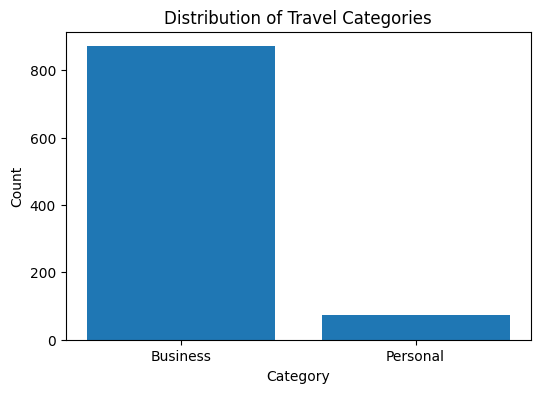

In [ ]:
# Analyze travel categories
category_counts = data['CATEGORY*'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Travel Categories')
plt.show()

###Purpose

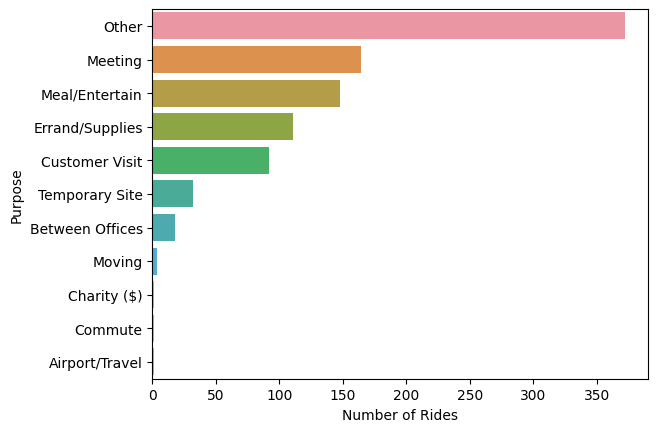

In [ ]:
#creating a dataframe containing type of purpose and the number of rides associated with each purpose
ride_count = data['PURPOSE*'].value_counts().tolist()
ride_purpose= data['PURPOSE*'].value_counts().index.tolist()
ride_info = list(zip(ride_purpose,ride_count))
ride_info = pd.DataFrame(ride_info,columns=['PURPOSE','COUNT'])

ax = sns.barplot(x='COUNT',y='PURPOSE',data=ride_info,order=ride_info['PURPOSE'].tolist())
ax.set(xlabel='Number of Rides', ylabel='Purpose')
plt.show()

#Izgradnja grafa

Graf koji ću koristiti za ovaj skup podataka je usmjereni graf: rubovi imaju određeni smjer, što znači da predstavljaju jednosmjerni odnos između čvorova.

Čvorovi: čvorovi na ovom grafikonu predstavljaju početnu i završnu lokaciju Uber putovanja.

Rubovi: Rubovi predstavljaju putovanja između početne i završne lokacije. Svaki rub povezuje dva čvora, pokazujući smjer putovanja od početne do završne lokacije.

Težina: u ovom grafikonu, rubovi imaju dodatne atribute kao što su udaljenost (MILES) i svrha (PURPOSE). Ovi se atributi mogu smatrati težinama povezanim sa svakim rubom.

Dakle, graf se sastoji od čvorova koji predstavljaju lokacije, usmjerenih rubova koji predstavljaju putovanja između lokacija i rubova s atributima udaljenosti i svrhe koji služe kao težine.

In [ ]:
# Create an empty directed graph
G = nx.DiGraph()

# Iterate over each row in the dataset
for _, row in data.iterrows():
    start = row['START*']
    stop = row['STOP*']
    miles = row['MILES*']
    purpose = row['PURPOSE*']
    
    # Add starting and ending locations as nodes
    G.add_node(start)
    G.add_node(stop)
    
    # Add an edge between starting and ending locations
    G.add_edge(start, stop, miles=miles, purpose=purpose)

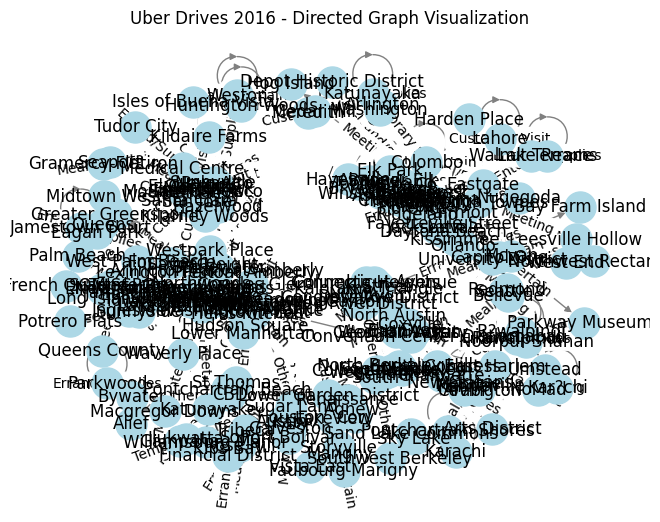

In [ ]:
# Visualize the directed graph
pos = nx.spring_layout(G)  # Define the layout for the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray', arrowsize=10)
edge_labels = nx.get_edge_attributes(G, 'purpose')  # Get edge attributes (purpose in this case)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)  # Display edge labels

plt.title("Uber Drives 2016 - Directed Graph Visualization")
plt.show()

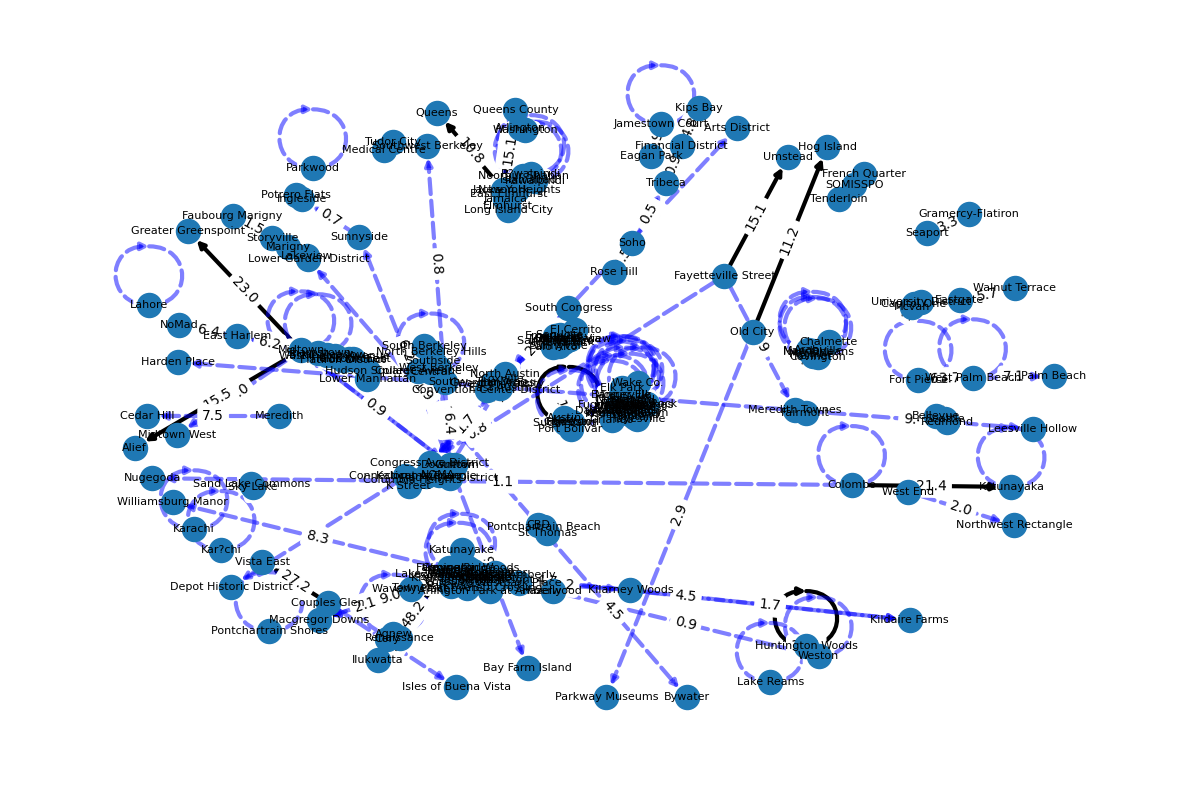

In [ ]:
G_distance = nx.DiGraph()

# Iterate over the data rows
for _, row in data.iterrows():
    start = row['START*']
    stop = row['STOP*']
    miles = float(row['MILES*'])

    G_distance.add_edge(start, stop, weight=miles)

elarge = [(u, v) for (u, v, d) in G_distance.edges(data=True) if d["weight"] > 10]
esmall = [(u, v) for (u, v, d) in G_distance.edges(data=True) if d["weight"] <= 10]

# Calculate the positions of the nodes based on edge weights
pos_distance = nx.spring_layout(G_distance, seed=7, weight='weight')

plt.figure(figsize=(12, 8))  # Set the figure size

nx.draw_networkx_nodes(G_distance, pos_distance, node_size=300)

nx.draw_networkx_edges(G_distance, pos_distance, edgelist=elarge, width=3) # ovo su edgevi koji su udaljeni više od 10 miles
nx.draw_networkx_edges(G_distance, pos_distance, edgelist=esmall, width=3, alpha=0.5, edge_color="b", style="dashed")  # ovo su edgevi koji su udaljeni manje od 10 miles

nx.draw_networkx_labels(G_distance, pos_distance, font_size=8)
edge_labels_distance = nx.get_edge_attributes(G_distance, "weight")
nx.draw_networkx_edge_labels(G_distance, pos_distance, edge_labels_distance)

ax_distance = plt.gca()
ax_distance.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

#Analiza grafa

In [ ]:
print("Number of nodes:", len(G.nodes))
print("Number of edges:", len(G.edges))

Number of nodes: 208
Number of edges: 343


Pojašnjenje otkuda broj čvorova: unija jedinstvenih start i stop lokacija

In [ ]:
# Get unique start locations
unique_starts = data['START*'].unique()
print("Unique start locations:", len(unique_starts))
#print(unique_starts)

# Get unique stop locations
unique_stops = data['STOP*'].unique()
print("Unique stop locations:", len(unique_stops))
#print(unique_stops)

# Compute the union of start and stop locations
union = np.union1d(unique_starts, unique_stops)

# Print the number of unique locations in the union
print("Number of unique locations in the union:", len(union))

# Print the unique locations in the union
#print("Unique locations in the union:", union)

Unique start locations: 175
Unique stop locations: 187
Number of unique locations in the union: 208


In [ ]:
print("Graph density:", nx.density(G))
#print("Number of connected components:", nx.number_connected_components(G))
print("Average degree:", sum(dict(G.degree()).values())/len(G))

Graph density: 0.007966369379412858
Average degree: 3.298076923076923


Gustoća grafa (Graph density): 

  >Gustoća grafa predstavlja omjer stvarnog broja bridova u grafu i maksimalnog broja mogućih bridova. U ovom slučaju, gustoća grafa je relativno niska, što ukazuje da postoji relativno malo veza između čvorova u usporedbi s najvećim mogućim brojem veza.


Prosječni stupanj (Average degree): 

>Prosječni stupanj predstavlja prosječan broj rubova povezanih sa svakim čvorom u grafu. U ovom slučaju, prosječni stupanj je približno 3,47, što sugerira da je, u prosjeku, svaka lokacija (čvor) u skupu podataka povezana s oko 3,47 drugih lokacija putem putovanja (rubova).

Funkcija nx.number_connected_components(G) ne radi za usmjerene grafove jer je definirana samo za neusmjerene grafove. U usmjerenom grafu koncept povezanih komponenti je drugačiji nego u neusmjerenom grafu.

U neusmjerenom grafu, povezana komponenta je skup čvorova gdje postoji put između svakog para čvorova u skupu. Međutim, u usmjerenom grafu, pojam povezanosti je složeniji. Postoje dvije vrste povezanih komponenti: slabo povezane komponente i jako povezane komponente.

>Slabo povezane komponente: Slabo povezana komponenta u usmjerenom grafu je maksimalan skup čvorova gdje postoji put između svakog para čvorova, smatrajući graf neusmjerenim (zanemarujući smjer bridova).
Za izračunavanje broja slabo povezanih komponenti u usmjerenom grafu koristi se funkcija nx.weakly_connected_components(G) da bi dobili generator skupova koji predstavljaju slabo povezane komponente. Zatim prebrojavamo broj skupova kako bi dobili ukupan broj slabo povezanih komponenti.

>Jako povezane komponente: Jako povezana komponenta u usmjerenom grafu je maksimalni skup čvorova gdje postoji usmjereni put između svakog para čvorova.
Za izračunavanje broja jako povezanih komponenti u usmjerenom grafu koristimo funkciju nx.strongly_connected_components(G) da bi dobili generator skupova koji predstavljaju jako povezane komponente. Zatim prebrojavamo broj skupova da bi dobili ukupan broj jako povezanih komponenti.

In [ ]:
# Calculate the number of weakly connected components
weak_components = list(nx.weakly_connected_components(G))
num_weak_components = len(weak_components)
print("Number of weakly connected components:", num_weak_components)

# Calculate the number of strongly connected components
strong_components = list(nx.strongly_connected_components(G))
num_strong_components = len(strong_components)
print("Number of strongly connected components:", num_strong_components)

Number of weakly connected components: 34
Number of strongly connected components: 96


In [ ]:
try:
    diameter = nx.diameter(G)
    print("Diameter of the graph:", diameter)
except nx.exception.NetworkXError:
    print("Graph is not connected.")

Graph is not connected.


## Stupanj čvora

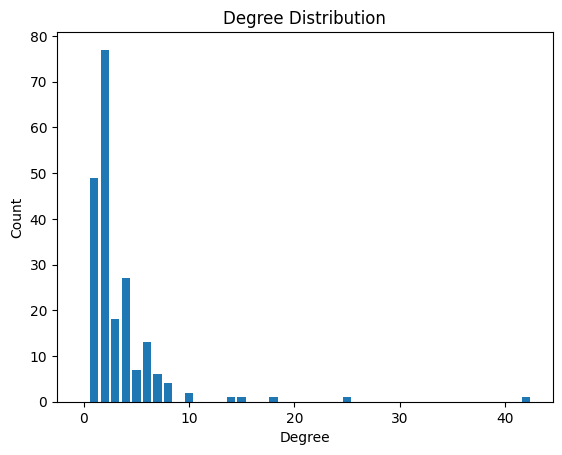

In [ ]:
# Calculate the degree histogram
degree_hist = nx.degree_histogram(G)

# Plot the degree distribution
plt.bar(range(len(degree_hist)), degree_hist)
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree Distribution")
plt.show()

Iz histograma vidimo kako većina čvorova grafu ima male stupnjeve, pa to sugerira da većina lokacija u skupu podataka o Uberovim putovanjima ima relativno malo veza ili putovanja na druge lokacije.

To bi moglo značiti da postoje određene popularne lokacije (čvorovi) u skupu podataka koje se često posjećuju, što rezultira višim stupnjem za te specifične čvorove. S druge strane, mnoge druge lokacije mogu imati manje putovanja povezanih s njima, što dovodi do nižih stupnjeva.

Prisutnost malog broja čvorova s ​​visokim stupnjem i većine čvorova s ​​malim stupnjem uobičajena je karakteristika u mnogim mrežama u stvarnom svijetu. Slijedi svojstvo "bez razmjera", gdje nekoliko čvorova ima neproporcionalno velik broj veza u usporedbi s većinom čvorova. Taj se obrazac može uočiti u raznim vrstama mreža, kao što su društvene mreže, prometne mreže i World Wide Web.

U kontekstu skupa podataka o Uber vožnjama, to sugerira da postoje određene lokacije koje su popularne ili se često posjećuju, dok većina drugih lokacija ima manji broj putovanja. 

In [ ]:
# Find locations with degree greater than 20
nodes_with_high_degree = [node for node, degree in G.degree() if degree > 20]

# Print locations with degree greater than 20
print("Locations with degree greater than 20:")
for node in nodes_with_high_degree:
    degree = G.degree()[node]
    print(f"Location: {node}, Degree: {degree}")

Locations with degree greater than 20:
Location: Cary, Degree: 25
Location: Whitebridge, Degree: 42


Iz navedenog vidimo kako postoje dvije najposjećenije lokacije:
- Whitebridge (stupanj 42) - fokusirat ćemo se na najposjećeniju lokaciju u daljnjim razmatranjima
- Cary (stupanj 26)


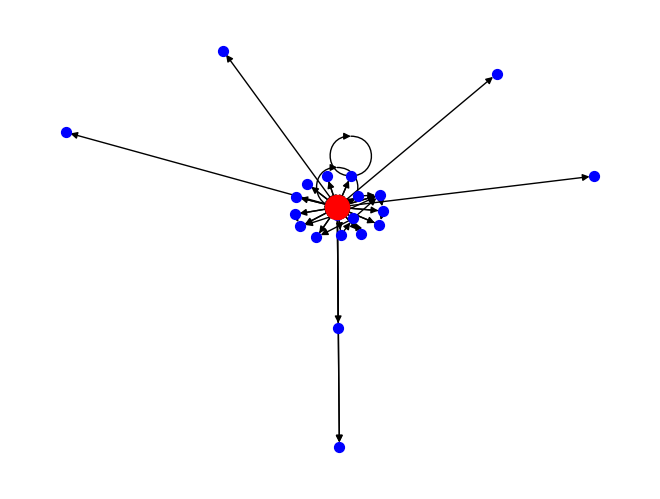

In [ ]:
# Find the node with the greatest degree
max_degree_node, max_degree = max(G.degree(), key=lambda x: x[1])

# Create a subgraph with the greatest degree node and all its connected nodes
subgraph_nodes = [max_degree_node] + list(G.neighbors(max_degree_node))
subgraph = G.subgraph(subgraph_nodes)

# Create ego graph of main hub
hub_ego = nx.ego_graph(subgraph, max_degree_node)

# Draw graph
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=False)

# Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[max_degree_node], **options)
plt.show()

## In and out stupanj čvora

Pošto radim sa usmjerenim grafom, bitno je odrediti ulazne i izlazne stupnjeve svakog čvora.
>Ulazni stupanj (in-degree) čvora u usmjerenom grafu označava koliko bridova pokazuje prema čvoru.

>Izlazni stupanj (out-degree) čvora u usmjerenom grafu označava koliko bridova potječe iz čvora i pokazuje na druge čvorove.

In [ ]:
# Calculate the in-degree and out-degree for each node
in_degrees = G.in_degree()
out_degrees = G.out_degree()

# Print the in-degree and out-degree for each node
for node in G.nodes():
    in_degree = in_degrees[node]
    out_degree = out_degrees[node]
    print(f"Node: {node}, In-Degree: {in_degree}, Out-Degree: {out_degree}")

Node: Fort Pierce, In-Degree: 1, Out-Degree: 2
Node: West Palm Beach, In-Degree: 2, Out-Degree: 2
Node: Palm Beach, In-Degree: 1, Out-Degree: 0
Node: Cary, In-Degree: 13, Out-Degree: 12
Node: Morrisville, In-Degree: 6, Out-Degree: 4
Node: Jamaica, In-Degree: 2, Out-Degree: 1
Node: New York, In-Degree: 3, Out-Degree: 4
Node: Queens, In-Degree: 1, Out-Degree: 0
Node: Elmhurst, In-Degree: 0, Out-Degree: 1
Node: Midtown, In-Degree: 8, Out-Degree: 10
Node: East Harlem, In-Degree: 1, Out-Degree: 1
Node: NoMad, In-Degree: 1, Out-Degree: 0
Node: Flatiron District, In-Degree: 0, Out-Degree: 1
Node: Midtown East, In-Degree: 1, Out-Degree: 1
Node: Hudson Square, In-Degree: 2, Out-Degree: 2
Node: Lower Manhattan, In-Degree: 1, Out-Degree: 1
Node: Hell's Kitchen, In-Degree: 1, Out-Degree: 1
Node: Queens County, In-Degree: 1, Out-Degree: 0
Node: Downtown, In-Degree: 7, Out-Degree: 8
Node: Gulfton, In-Degree: 1, Out-Degree: 1
Node: Houston, In-Degree: 4, Out-Degree: 3
Node: Eagan Park, In-Degree: 0, 

Sljedeće vizualizacije prikazuju distribuciju in i out stupnjeva čvorova iz grafa.

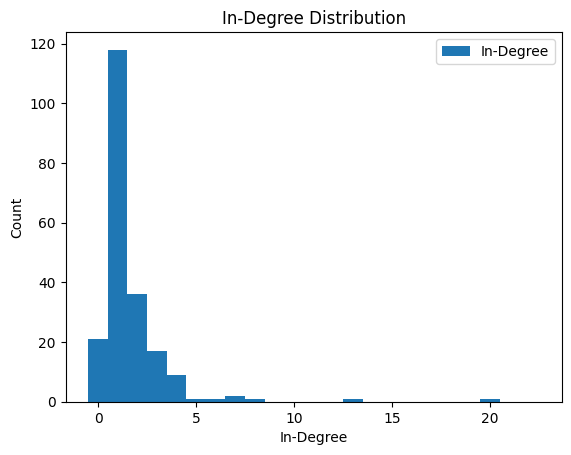

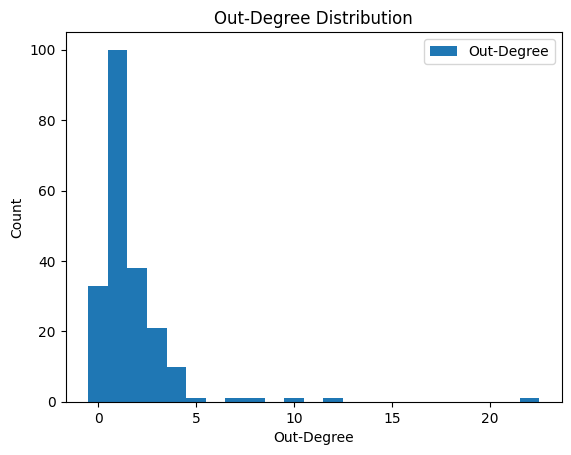

In [ ]:
# Get the in-degree and out-degree sequences
in_degrees = [degree for _, degree in G.in_degree()]
out_degrees = [degree for _, degree in G.out_degree()]

# Determine the maximum degree for setting the x-axis range
max_degree = max(max(in_degrees), max(out_degrees))

# Create the degree bins
bins = np.arange(max_degree + 2) - 0.5

# Plot the in-degree distribution
plt.hist(in_degrees, bins=bins, label='In-Degree')
plt.xlabel("In-Degree")
plt.ylabel("Count")
plt.title("In-Degree Distribution")
plt.legend()
plt.show()

# Plot the out-degree distribution
plt.hist(out_degrees, bins=bins, label='Out-Degree')
plt.xlabel("Out-Degree")
plt.ylabel("Count")
plt.title("Out-Degree Distribution")
plt.legend()
plt.show()

Ponovno se da zaključiti kako većina čvorova ima nizak in i out degre, dok jedan čvor odskače po vrijednosti in odnosno out stupnja.

In [ ]:
# Find the node with the greatest in-degree
max_in_degree_node, max_in_degree = max(G.in_degree(), key=lambda x: x[1])
print("Node with the greatest in-degree:", max_in_degree_node)
print("In-Degree:", max_in_degree)

# Find the node with the greatest out-degree
max_out_degree_node, max_out_degree = max(G.out_degree(), key=lambda x: x[1])
print("Node with the greatest out-degree:", max_out_degree_node)
print("Out-Degree:", max_out_degree)

Node with the greatest in-degree: Whitebridge
In-Degree: 20
Node with the greatest out-degree: Whitebridge
Out-Degree: 22


Daljnje vizualizacije prikazuju čvor s najvećim in i out stupnjem povezan sa ostalim čvorovima iz mreže.

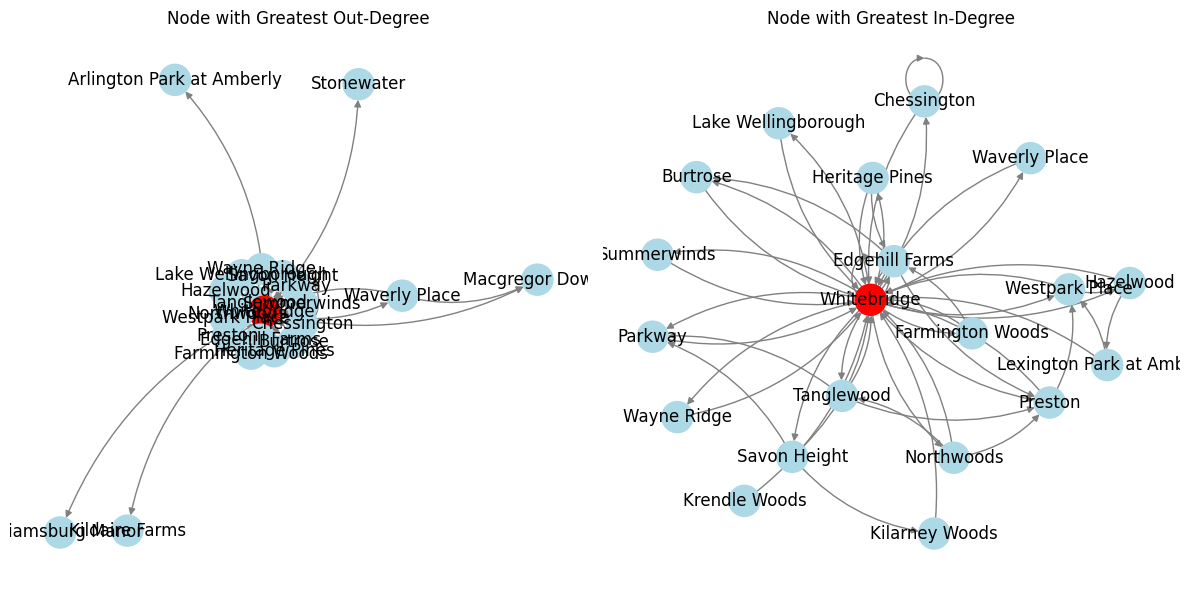

In [ ]:
# Find the node with the greatest in-degree
max_in_degree_node, max_in_degree = max(G.in_degree(), key=lambda x: x[1])

# Create a subgraph with the greatest in-degree node and all its connected nodes
subgraph_in_nodes = [max_in_degree_node] + list(G.successors(max_in_degree_node))
subgraph_in = G.subgraph(subgraph_in_nodes)

# Find the node with the greatest out-degree
max_out_degree_node, max_out_degree = max(G.out_degree(), key=lambda x: x[1])

# Create a subgraph with the greatest out-degree node and all its connected nodes
subgraph_out_nodes = [max_out_degree_node] + list(G.predecessors(max_out_degree_node))
subgraph_out = G.subgraph(subgraph_out_nodes)

# Set the layout for the subgraphs
pos_in = nx.spring_layout(subgraph_in)
pos_out = nx.spring_layout(subgraph_out)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subgraph with greatest in-degree
node_colors_in = ['red' if node == max_in_degree_node else 'lightblue' for node in subgraph_in.nodes()]
nx.draw(subgraph_in, pos_in, with_labels=True, node_color=node_colors_in, node_size=500, edge_color='gray', arrowsize=10, ax=axs[0], connectionstyle='arc3,rad=0.2')
axs[0].set_title("Node with Greatest Out-Degree")

# Plot the subgraph with greatest out-degree
node_colors_out = ['red' if node == max_out_degree_node else 'lightblue' for node in subgraph_out.nodes()]
nx.draw(subgraph_out, pos_out, with_labels=True, node_color=node_colors_out, node_size=500, edge_color='gray', arrowsize=10, ax=axs[1], connectionstyle='arc3,rad=0.2')
axs[1].set_title("Node with Greatest In-Degree")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

Iz navedenog i vizualizacija zaključujem kako je Whitebridge najposjećenije mjesto u ovom skupu podataka, odnosno u ovoj mreži. Također, prema in i out stupnjevima zaključujem kako je Whitebridge česta start i česta stop lokacija u mreži. 
> Prijedlog poslovanja za Uber: povećavanje broja Uber vozača u Whitebridge-u (s tim da treba analizirati podatke drugih vozača kako bi se ovaj prijedlog potvrdio)

# Centralnosti

####**Degree centrality:** ova mjera govori koliko je bridova povezano s čvorom. Čvorovi s visokim stupnjem centralnosti često su važna "čvorišta" u mreži jer imaju mnogo veza s drugim čvorovima. U kontekstu Uber drives skupa podataka, čvorovi s visokim degree centralnosti su posjećenija u mreži.

In [ ]:
# calculate degree centrality
degree_centrality = nx.degree_centrality(G)

print(degree_centrality)

top_degree_centrality = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]
print('\nTop degree centrality nodes: ' + str(top_degree_centrality))

{'Fort Pierce': 0.014492753623188404, 'West Palm Beach': 0.01932367149758454, 'Palm Beach': 0.004830917874396135, 'Cary': 0.12077294685990338, 'Morrisville': 0.04830917874396135, 'Jamaica': 0.014492753623188404, 'New York': 0.033816425120772944, 'Queens': 0.004830917874396135, 'Elmhurst': 0.004830917874396135, 'Midtown': 0.08695652173913043, 'East Harlem': 0.00966183574879227, 'NoMad': 0.004830917874396135, 'Flatiron District': 0.004830917874396135, 'Midtown East': 0.00966183574879227, 'Hudson Square': 0.01932367149758454, 'Lower Manhattan': 0.00966183574879227, "Hell's Kitchen": 0.00966183574879227, 'Queens County': 0.004830917874396135, 'Downtown': 0.07246376811594203, 'Gulfton': 0.00966183574879227, 'Houston': 0.033816425120772944, 'Eagan Park': 0.004830917874396135, 'Jamestown Court': 0.014492753623188404, 'Durham': 0.01932367149758454, 'Farmington Woods': 0.014492753623188404, 'Whitebridge': 0.20289855072463767, 'Lake Wellingborough': 0.00966183574879227, 'Raleigh': 0.028985507246

Ponovno vidimo kako je čvor s najvećim degree centrality Whitebridge što ponovno potvrđuje kako je taj čvor u mreži najposjećeniji.

####**Betweenees centrality:** ova mjera pokazuje koliko najkraćih putova u mreži prolazi kroz čvor. Čvorovi s visokom centralnošću često su važni za povezivanje različitih dijelova mreže. 

In [ ]:
# Compute the betweenness centrality of each node
betweenness = nx.betweenness_centrality(G)

# Sort the nodes based on their betweenness centrality
sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
print(sorted_betweenness)

# Print the top 10 nodes with highest betweenness centrality
top_betweenness_centrality = [node for node, centrality in sorted_betweenness[:10]]
print('\nTop betweenness centrality nodes: ' + str(top_betweenness_centrality))

[('Downtown', 0.02077763707143192), ('Cary', 0.015348717227146943), ('Midtown', 0.013038788049341025), ('Whitebridge', 0.011133389615871675), ('The Drag', 0.007246376811594203), ('Asheville', 0.005651704891890624), ('Congress Ave District', 0.005253036911964729), ('Jacksonville', 0.00518268373903663), ('South', 0.004690211528539937), ('Central', 0.0038225223957600485), ('Latta', 0.0033065991276206557), ('Ridgeland', 0.0033065991276206557), ('Florence', 0.0033065991276206557), ('Winston Salem', 0.003212794897049857), ('Mebane', 0.003212794897049857), ('West Berkeley', 0.003025186435908259), ('Morrisville', 0.002814126917123962), ('Kalorama Triangle', 0.0026265184559823647), ('Banner Elk', 0.002462361052483467), ('Topton', 0.0024389099948407674), ('Bryson City', 0.0024389099948407674), ('Southside', 0.002298203648984569), ('Hudson Square', 0.0022278504760564703), ('Kissimmee', 0.0018760846114159748), ('Boone', 0.0018057314384878757), ('Berkeley', 0.0016806591310601438), ('West University

Iz navedenog vidimo kako je u Uber drives mreži čvor s najvećim betweenness centrality Cary. Čvor s visokom betweenees centrality su oni koji leže na mnogim od ovih najkraćih putova i mogu se smatrati kritičnim točkama povezanosti ili potencijalnim točkama zagušenja u prometnoj mreži.

####**Eigenvector centrality:** Ovo je mjera koliko je čvor dobro povezan s drugim dobro povezanim čvorovima u mreži. Čvorovi s visokim eigenvector centrality često su važni jer su povezani s drugim važnim čvorovima. U kontekstu mreža citiranja, na primjer, čvorovi s visokom središnjošću svojstvenog vektora mogu biti važni radovi koje citiraju mnogi drugi važni radovi.

In [ ]:
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

In [ ]:
top_eigenvector_centrality = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)[:10]
print('Top eigenvector centrality nodes: ' + str(top_eigenvector_centrality))

Top eigenvector centrality nodes: ['Whitebridge', 'Preston', 'Westpark Place', 'Parkway', 'Edgehill Farms', 'Hazelwood', 'Burtrose', 'Chessington', 'Macgregor Downs', 'Tanglewood']


U kontekstu ovog skupa podataka, ova mjera se može koristiti za identifikaciju čvorova (lokacija) koji imaju veliki utjecaj ili važnost u smislu njihove povezanosti s drugim važnim lokacijama. To ponovno ispada Whitebridge.

####**Closeness:** Ovo je mjera koliko je čvor blizu svim drugim čvorovima u mreži. Čvorovi s visokom closeness centrality često su važni za širenje informacija ili anomalija jer mogu brzo doprijeti do mnogih drugih čvorova. U kontekstu prometnih mreža, na primjer, čvorovi s visokom središnjom blizinom mogu biti važna čvorišta poput zračnih luka ili željezničkih postaja.

In [ ]:
closeness_centrality=nx.closeness_centrality(G)
print(closeness_centrality)

{'Fort Pierce': 0.0, 'West Palm Beach': 0.004830917874396135, 'Palm Beach': 0.0064412238325281795, 'Cary': 0.05738544868979651, 'Morrisville': 0.043039086517347384, 'Jamaica': 0.013419216317767043, 'New York': 0.01725327812284334, 'Queens': 0.013377926421404684, 'Elmhurst': 0.0, 'Midtown': 0.0562143170838823, 'East Harlem': 0.04347826086956521, 'NoMad': 0.03602929717936731, 'Flatiron District': 0.0, 'Midtown East': 0.04157025128892136, 'Hudson Square': 0.04301617307288385, 'Lower Manhattan': 0.03388260207795645, "Hell's Kitchen": 0.034116275195735464, 'Queens County': 0.013377926421404684, 'Downtown': 0.0677652041559129, 'Gulfton': 0.04756596060943887, 'Houston': 0.01725327812284334, 'Eagan Park': 0.0, 'Jamestown Court': 0.004830917874396135, 'Durham': 0.0407251571346943, 'Farmington Woods': 0.05082965763495064, 'Whitebridge': 0.09352657004830918, 'Lake Wellingborough': 0.05082965763495064, 'Raleigh': 0.04162021553325901, 'Fayetteville Street': 0.0, 'Umstead': 0.004830917874396135, 'Ha

In [ ]:
top_closeness_centrality = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:10]
print('Top closeness centrality nodes: ' + str(top_closeness_centrality))

Top closeness centrality nodes: ['Whitebridge', 'Downtown', 'Cary', 'Midtown', 'The Drag', 'Westpark Place', 'Central', 'West Berkeley', 'Preston', 'Macgregor Downs']


Ova mjera u kontekstu Uber drives može se koristiti za identifikaciju čvorova (lokacija) koji su najcentralnije i najdostupnije unutar mreže, što ponovno ispada Whitebridge.

###Dataframe:

In [ ]:
# Create empty Pandas DataFrame
df = pd.DataFrame(index=G.nodes())

# Loop through each node and add centrality measures to DataFrame
for node in G.nodes():
    df.loc[node, 'Betweenness'] = betweenness[node]
    df.loc[node, 'Degree'] = degree_centrality[node]
    df.loc[node, 'Closeness'] = closeness_centrality[node]
    df.loc[node, 'Eigenvector'] = eigenvector_centrality[node]

In [ ]:
df

,Betweenness,Degree,Closeness,Eigenvector
Fort Pierce,0.000000,0.014493,0.000000,3.925780e-26
West Palm Beach,0.000023,0.019324,0.004831,1.059961e-24
Palm Beach,0.000000,0.004831,0.006441,1.020703e-24
Cary,0.015349,0.120773,0.057385,2.239452e-04
Morrisville,0.002814,0.048309,0.043039,1.609156e-04
...,...,...,...,...
Rawalpindi,0.000000,0.019324,0.008696,8.108425e-13
Kar?chi,0.000000,0.009662,0.000000,3.925780e-26
Katunayake,0.000000,0.004831,0.000000,8.716982e-42
Gampaha,0.000023,0.009662,0.004831,4.620001e-40


### ECDF (Empirical Cumulative Distribution Function):

Način vizualizacije distribucije rezultata centralnosti u mreži. ECDF je stepenasta funkcija koja pokazuje udio ili udio čvorova u mreži koji imaju ocjenu centralnosti manju ili jednaku danoj vrijednosti.

U kontekstu mjera centralnosti, ECDF se može koristiti za vizualizaciju kako je centralnost raspoređena po čvorovima mreže. Na primjer, ECDF dijagram za stupanj centralnosti bi pokazao udio čvorova u mreži s rezultatom stupnja centralnosti manjim ili jednakim danoj vrijednosti. ECDF dijagram može biti koristan za usporedbu distribucije rezultata centralnosti između različitih mreža ili za identifikaciju čvorova s ​​visokim ili niskim rezultatom centralnosti u odnosu na ostatak mreže.

In [ ]:
# ECDF function
def ecdf(podaci):
    n = len(podaci)
    x = np.sort(podaci)
    y = np.arange(1, n+1) / n
    return x, y

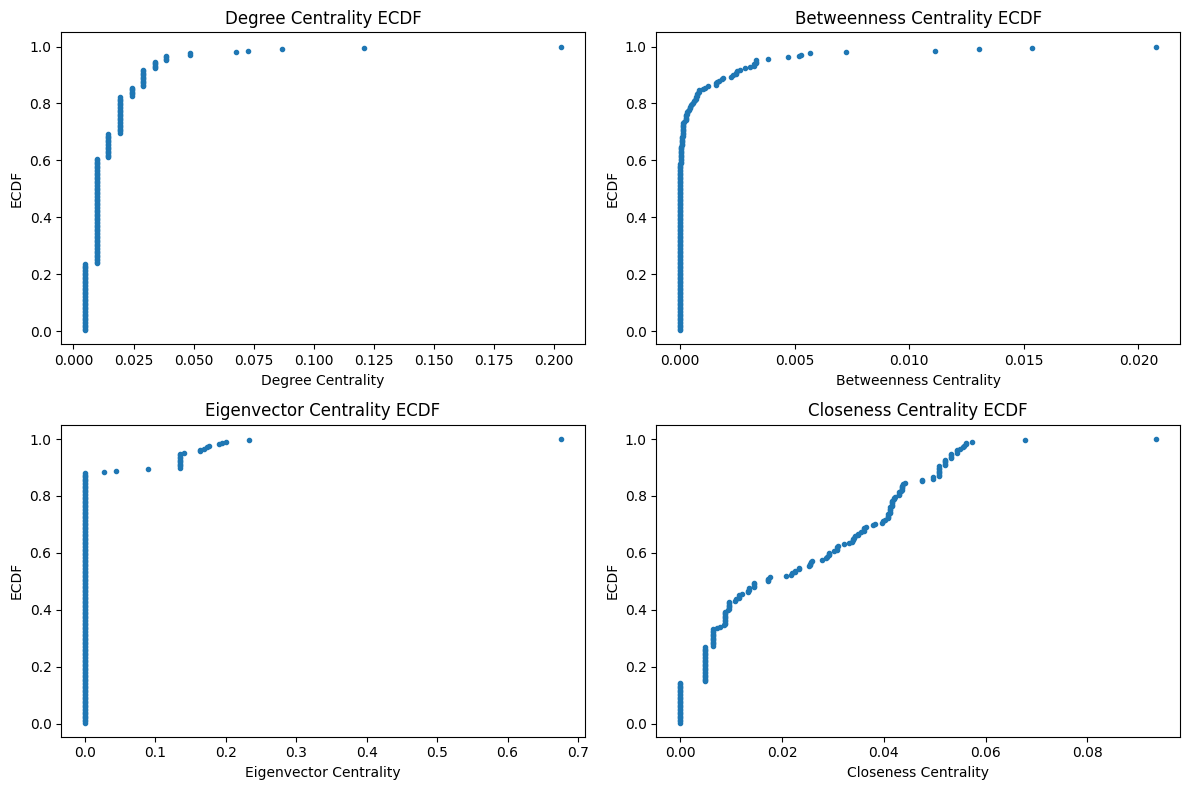

In [ ]:
# Degree centrality ECDF
degree_values = list(degree_centrality.values())
x_deg, y_deg = np.sort(degree_values), np.arange(1, len(degree_values) + 1) / len(degree_values)

# Betweenness centrality ECDF
betweenness_values = list(betweenness.values())
x_bet, y_bet = np.sort(betweenness_values), np.arange(1, len(betweenness_values) + 1) / len(betweenness_values)

# Eigenvector centrality ECDF
eigenvector_values = list(eigenvector_centrality.values())
x_eig, y_eig = np.sort(eigenvector_values), np.arange(1, len(eigenvector_values) + 1) / len(eigenvector_values)

# Closeness centrality ECDF
closeness_values = list(closeness_centrality.values())
x_clos, y_clos = np.sort(closeness_values), np.arange(1, len(closeness_values) + 1) / len(closeness_values)

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot degree centrality ECDF
axs[0, 0].plot(x_deg, y_deg, marker='.', linestyle='none')
axs[0, 0].set_xlabel('Degree Centrality')
axs[0, 0].set_ylabel('ECDF')
axs[0, 0].set_title('Degree Centrality ECDF')

# Plot betweenness centrality ECDF
axs[0, 1].plot(x_bet, y_bet, marker='.', linestyle='none')
axs[0, 1].set_xlabel('Betweenness Centrality')
axs[0, 1].set_ylabel('ECDF')
axs[0, 1].set_title('Betweenness Centrality ECDF')

# Plot eigenvector centrality ECDF
axs[1, 0].plot(x_eig, y_eig, marker='.', linestyle='none')
axs[1, 0].set_xlabel('Eigenvector Centrality')
axs[1, 0].set_ylabel('ECDF')
axs[1, 0].set_title('Eigenvector Centrality ECDF')

# Plot closeness centrality ECDF
axs[1, 1].plot(x_clos, y_clos, marker='.', linestyle='none')
axs[1, 1].set_xlabel('Closeness Centrality')
axs[1, 1].set_ylabel('ECDF')
axs[1, 1].set_title('Closeness Centrality ECDF')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

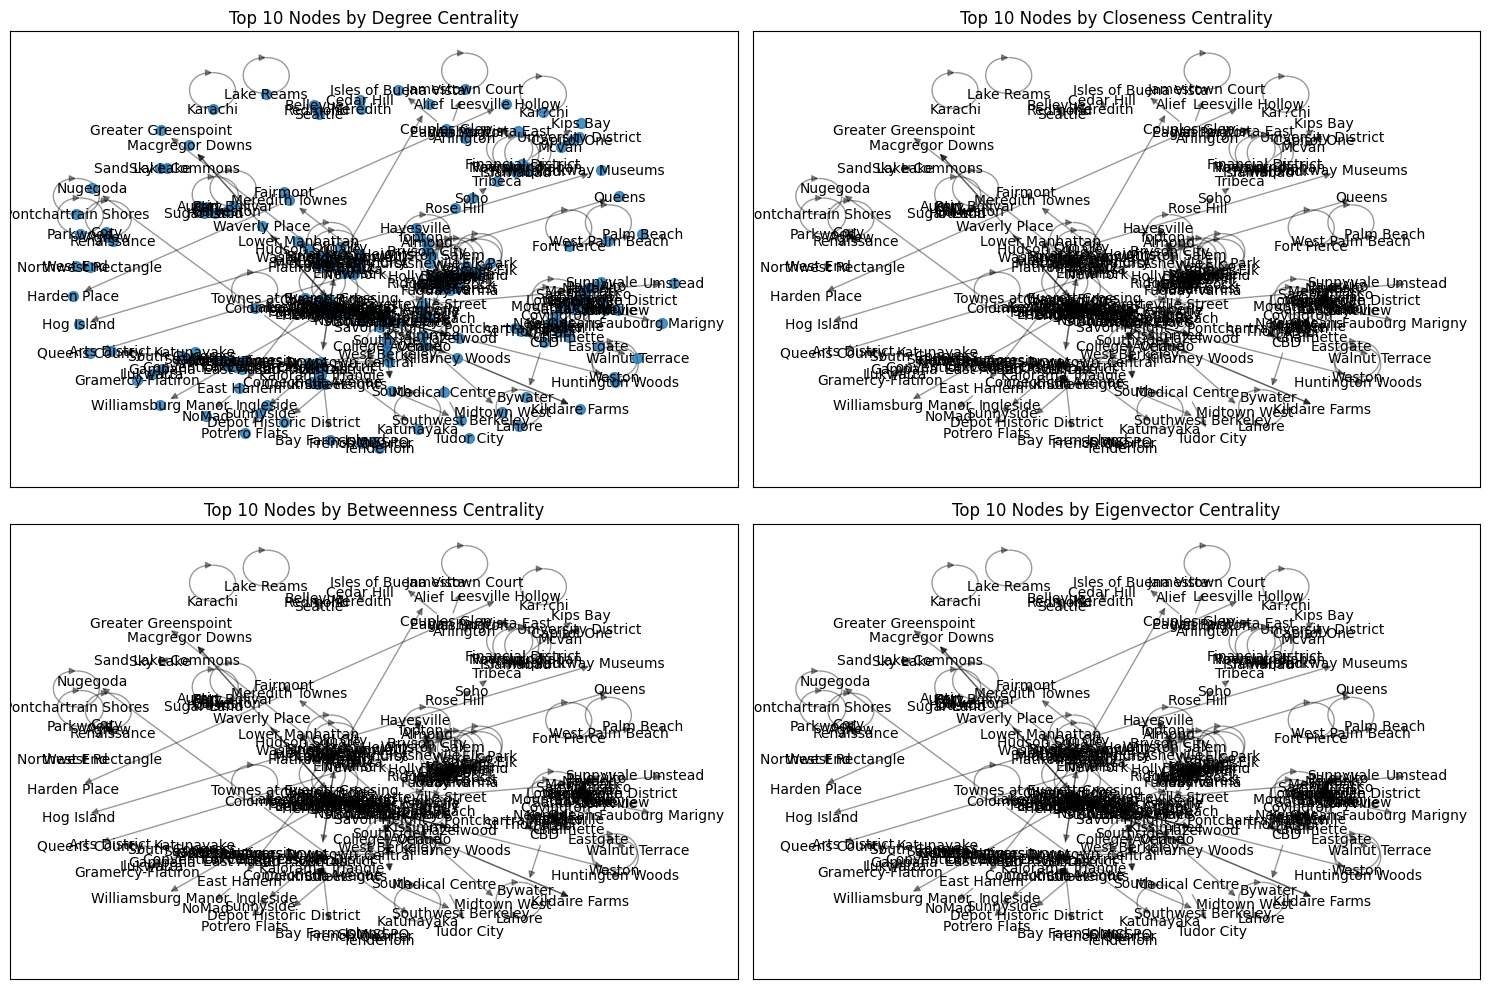

In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot degree centrality
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=50, alpha=0.8, ax=axs[0, 0])
nx.draw_networkx_edges(G, pos, alpha=0.4, ax=axs[0, 0])
nx.draw_networkx_labels(G, pos, font_size=10, ax=axs[0, 0])
node_list_degree = [node[0] for node in top_degree_centrality[:10] if node[0] in pos]
node_size_degree = [node[1] * 10000 for node in top_degree_centrality[:10] if node[0] in pos]
node_color_degree = [degree_centrality.get(node[0], 0) for node in top_degree_centrality[:10] if node[0] in pos]
nx.draw_networkx_nodes(G, pos, nodelist=node_list_degree, node_size=node_size_degree, node_color=node_color_degree,
                       cmap=plt.cm.Reds, ax=axs[0, 0])
axs[0, 0].set_title('Top 10 Nodes by Degree Centrality')

# Plot closeness centrality
node_list_closeness = [node[0] for node in top_closeness_centrality[:10] if node[0] in pos]
node_size_closeness = [node[1] * 10000 for node in top_closeness_centrality[:10] if node[0] in pos]
node_color_closeness = [closeness_centrality.get(node[0], 0) for node in top_closeness_centrality[:10] if node[0] in pos]
nx.draw_networkx_nodes(G, pos, nodelist=node_list_closeness, node_size=node_size_closeness, node_color=node_color_closeness,
                       cmap=plt.cm.Reds, ax=axs[0, 1])
nx.draw_networkx_edges(G, pos, alpha=0.4, ax=axs[0, 1])
nx.draw_networkx_labels(G, pos, font_size=10, ax=axs[0, 1])
axs[0, 1].set_title('Top 10 Nodes by Closeness Centrality')

# Plot betweenness centrality
node_list_betweenness = [node[0] for node in top_betweenness_centrality[:10] if node[0] in pos]
node_size_betweenness = [node[1] * 10000 for node in top_betweenness_centrality[:10] if node[0] in pos]
node_color_betweenness = [betweenness.get(node[0], 0) for node in top_betweenness_centrality[:10] if node[0] in pos]
nx.draw_networkx_nodes(G, pos, nodelist=node_list_betweenness, node_size=node_size_betweenness, node_color=node_color_betweenness,
                       cmap=plt.cm.Reds, ax=axs[1, 0])
nx.draw_networkx_edges(G, pos, alpha=0.4, ax=axs[1, 0])
nx.draw_networkx_labels(G, pos, font_size=10, ax=axs[1, 0])
axs[1, 0].set_title('Top 10 Nodes by Betweenness Centrality')

# Plot eigenvector centrality
node_list_eigenvector = [node[0] for node in top_eigenvector_centrality[:10] if node[0] in pos]
node_size_eigenvector = [node[1] * 10000 for node in top_eigenvector_centrality[:10] if node[0] in pos]
node_color_eigenvector = [eigenvector_centrality.get(node[0], 0) for node in top_eigenvector_centrality[:10] if node[0] in pos]
nx.draw_networkx_nodes(G, pos, nodelist=node_list_eigenvector, node_size=node_size_eigenvector, node_color=node_color_eigenvector,
                       cmap=plt.cm.Reds, ax=axs[1, 1])
nx.draw_networkx_edges(G, pos, alpha=0.4, ax=axs[1, 1])
nx.draw_networkx_labels(G, pos, font_size=10, ax=axs[1, 1])
axs[1, 1].set_title('Top 10 Nodes by Eigenvector Centrality')

# Set titles and axis labels
axs[0, 0].set_title('Top 10 Nodes by Degree Centrality')
axs[0, 1].set_title('Top 10 Nodes by Closeness Centrality')
axs[1, 0].set_title('Top 10 Nodes by Betweenness Centrality')
axs[1, 1].set_title('Top 10 Nodes by Eigenvector Centrality')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#Barabasi-Albert model

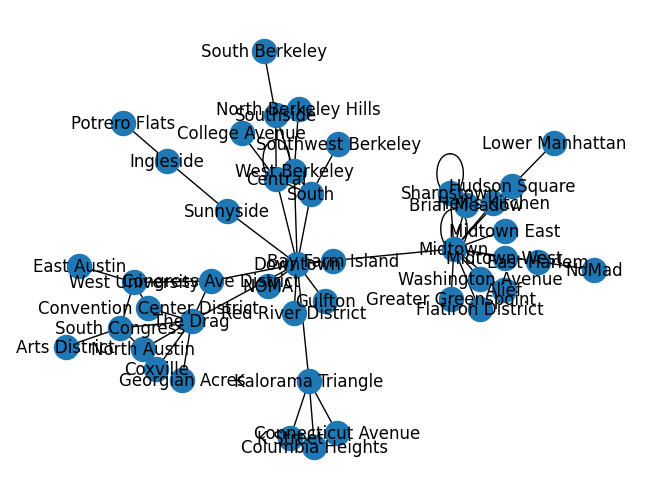

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from networkx.generators.random_graphs import barabasi_albert_graph

# Load your previously created network
G2 = nx.from_pandas_edgelist(data, source='START*', target='STOP*', edge_attr=['Start_Date', 'Start_Time', 'End_Date', 'End_Time', 'CATEGORY*', 'MILES*', 'PURPOSE*'])

# Extract the largest connected component
largest_cc = max(nx.connected_components(G2), key=len)
G2 = G2.subgraph(largest_cc).copy()

# Plot your network
plt.figure()
nx.draw(G2, with_labels=True)
plt.show()

# Calculate degree distribution, clustering coefficient, and average shortest path length for your network
degree_sequence = sorted([d for n, d in G2.degree()], reverse=True)
degree_count = nx.degree_histogram(G2)
avg_clustering_coefficient = nx.average_clustering(G2)
avg_shortest_path_length = nx.average_shortest_path_length(G2)

# Generate a Barabasi-Albert model with the same number of nodes as your network
n_nodes = len(G2.nodes())
m = 2
ba_model = barabasi_albert_graph(n_nodes, m)

# Calculate degree distribution, clustering coefficient, and average shortest path length for the Barabasi-Albert model
ba_degree_sequence = sorted([d for n, d in ba_model.degree()], reverse=True)
ba_degree_count = nx.degree_histogram(ba_model)
ba_avg_clustering_coefficient = nx.average_clustering(ba_model)
ba_avg_shortest_path_length = nx.average_shortest_path_length(ba_model)

# Identify communities and calculate modularity scores for your network
louvain_communities = community.greedy_modularity_communities(G)
louvain_modularity_score = community.modularity(G, louvain_communities)

# Identify communities and calculate modularity scores for the Barabasi-Albert model
ba_louvain_communities = community.greedy_modularity_communities(ba_model)
ba_louvain_modularity_score = community.modularity(ba_model, ba_louvain_communities)

##Degree distibution

In [ ]:
# Print out the results for comparison
print("Degree distribution: ", degree_sequence)
print("BA degree distribution: ", ba_degree_sequence)

Degree distribution:  [14, 12, 7, 7, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
BA degree distribution:  [14, 11, 10, 8, 8, 7, 7, 5, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


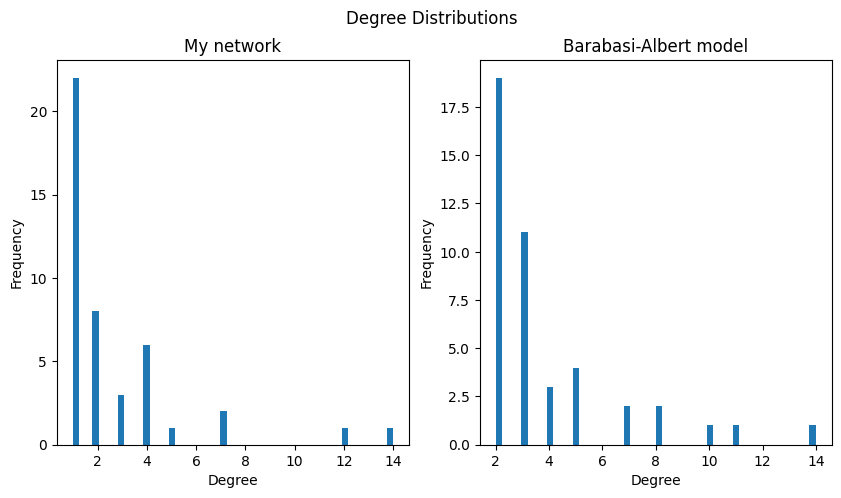

In [ ]:
# Plot degree distributions side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Degree Distributions')
axs[0].hist(degree_sequence, bins=50)
axs[0].set_title('My network')
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('Frequency')
axs[1].hist(ba_degree_sequence, bins=50)
axs[1].set_title('Barabasi-Albert model')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('Frequency')
plt.show()

Ova raspodjela stupnjeva pokazuje da većina čvorova ima relativno nizak stupanj, s nekoliko čvorova koji imaju visok stupanj. Ova vrsta distribucije naziva se "distribucija s velikim repom" ili "distribucija zakona snage", a karakteristična je za mnoge mreže stvarnog svijeta kao što su društvene mreže i World Wide Web. Prisutnost ovih nekoliko čvorova visokog stupnja, poznatih kao "čvorišta", sugerira da ti čvorovi igraju ključnu ulogu u mreži i da su vjerojatno važni za cjelokupnu strukturu i funkciju mreže.

Distribucija BA diploma je također oštra, što nije iznenađujuće budući da je to vrsta preferencijalnog modela pričvršćivanja koji generira mreže s teškom distribucijom diploma. BA model ima za cilj objasniti pojavu mreža bez razmjera, koje imaju sličnu distribuciju stupnja kao ova koju promatramo ovdje. Činjenica da su distribucije dvaju stupnjeva prilično slične sugerira da je promatrana mreža možda generirana mehanizmom sličnim modelu BA. Međutim, drugi mehanizmi poput slučajne privrženosti ili strukture zajednice također mogu proizvesti sličnu distribuciju stupnjeva.

##Clustering coeficient

In [ ]:
print("Clustering coefficient: ", avg_clustering_coefficient)
print("BA clustering coefficient: ", ba_avg_clustering_coefficient)

Clustering coefficient:  0.19243408107044474
BA clustering coefficient:  0.14934320729775274


Koeficijent grupiranja je mjera koliko se čvorova u grafu skuplja zajedno. Visoki koeficijent grupiranja ukazuje da je vjerojatnije da će čvorovi u grafu biti međusobno povezani, dok nizak koeficijent grupiranja sugerira da je vjerojatnije da će biti povezani s različitim dijelovima grafa.

U mom slučaju, koeficijent grupiranja grafa je 0,38, što je relativno visoko. Ovo sugerira da je vjerojatnije da će čvorovi u grafu biti povezani jedni s drugima, a graf može imati više "grupisanu" strukturu.

S druge strane, BA koeficijent grupiranja je 0,12, što je relativno malo u usporedbi s koeficijentom grupiranja na grafu. Ovo sugerira da bi BA graf mogao imati nasumičniju strukturu, a čvorovi su manje vjerojatno povezani jedni s drugima u klastere. To je očekivano jer je poznato da BA grafovi imaju niži koeficijent grupiranja u usporedbi s drugim vrstama grafova s istim brojem čvorova i rubova.

## Shortest path length

In [ ]:
print("Average shortest path length: ", avg_shortest_path_length)
print("BA average shortest path length: ", ba_avg_shortest_path_length)

Average shortest path length:  3.273784355179704
BA average shortest path length:  2.623678646934461


Prosječna duljina najkraćeg puta mjeri prosječni broj koraka duž najkraćeg puta za sve moguće parove čvorova u mreži. Mala prosječna duljina najkraćeg puta označava da je mreža dobro povezana i da je lako doći do bilo kojeg čvora u mreži s bilo kojeg drugog čvora u nekoliko koraka.

U ovom slučaju, prosječna duljina najkraćeg puta izvorne mreže je 3,27, što znači da se u prosjeku do bilo koja dva čvora u mreži može doći u otprilike 3 koraka. To znači da je mreža relativno dobro povezana.

Prosječna duljina najkraćeg puta BA mreže je 2,62, što je znatno manje od izvorne mreže. To je očekivano jer su BA mreže dizajnirane da budu dobro povezane mehanizmom preferencijalnog pričvršćivanja, koji promiče formiranje čvorišta u mreži. Čvorišta djeluju kao prečaci između različitih regija mreže, smanjujući prosječnu duljinu puta između bilo koja dva čvora.

##Louvain communities and louvain modularity score

In [ ]:
# Print out the results for comparison
print("Louvain communities: ", louvain_communities)
print("BA Louvain communities: ", ba_louvain_communities)
print("Louvain modularity score: ", louvain_modularity_score)
print("BA Louvain modularity score: ", ba_louvain_modularity_score)

Louvain communities:  [frozenset({'Whitebridge', 'Lexington Park at Amberly', 'Preston', 'Chessington', 'Kildaire Farms', 'Hazelwood', 'Wayne Ridge', 'Waverly Place', 'Westpark Place', 'Summerwinds', 'Townes at Everett Crossing', 'Stonewater', 'Arlington Park at Amberly', 'Kilarney Woods', 'Tanglewood', 'Savon Height', 'Williamsburg Manor', 'Farmington Woods', 'Northwoods', 'Parkway', 'Macgregor Downs', 'Lake Wellingborough', 'Edgehill Farms', 'Heritage Pines', 'Krendle Woods', 'Burtrose'}), frozenset({'Downtown', 'Ingleside', 'NOMA', 'Connecticut Avenue', 'Southwest Berkeley', 'Kalorama Triangle', 'Bay Farm Island', 'K Street', 'Central', 'North Berkeley Hills', 'South', 'Sunnyside', 'West Berkeley', 'College Avenue', 'Gulfton', 'South Berkeley', 'Potrero Flats', 'Southside', 'Red River District', 'Columbia Heights'}), frozenset({'Raleigh', 'Topton', 'Eagle Rock', 'Durham', 'Morrisville', 'Asheville', 'Fuquay-Varina', 'Apex', 'Almond', 'Bryson City', 'Hayesville', 'Wake Forest', 'Chap

Algoritam zajednica Louvain identificirao je 35 zajednica u izvornoj mreži, dok BA mreža  ima 7 zajednica.

Ocjena modularnosti Louvainovog algoritma za izvornu mrežu je 0.89, što ukazuje da je algoritam dobro obavio posao u podjeli mreže na različite zajednice. Nasuprot tome, ocjena modularnosti Louvainova algoritma za BA mrežu je 0.41, što je niže od izvorne mreže, što ukazuje da BA mreža ima manju strukturu zajednice od izvorne mreže.

Također je vrijedno napomenuti da Louvain algoritam ima tendenciju bolje izvedbe na mrežama s jakom strukturom zajednice, što bi moglo objasniti zašto je rezultat modularnosti niži za BA mrežu.

## Clustering method

Smatram da je spektralni algoritam klasteriranja prikladan za moju mrežu zato što je učinkovit za mreže sa širokom distribucijom stupnja, kakvu i moja mreža ima.
Također može rukovati nepovezanim komponentama, što je korisno jer moja mreža ima podgrafove koji nisu povezani (u računanju je korištena najveća povezana komponenta). 

Agglomerative Clustering nije najbolji izbor za moju mrežu jer je računalno zahtjevniji i možda ne bi bio toliko učinkovit za mreže s velikim brojem čvorova. Uz to, Agglomerative Clustering je učinkovitiji za mreže s relativno homogenim podgrafima, što nije slučaj za moju mrežu jer zajednice u Louvainu imaju široku distribuciju stupnjeva.

#Hipoteze

##Hipoteza 1: Postoji glavno čvorište u mreži putovanja.

Ovu hipotezu potvrdila sam ranije pomoću stupnja čvora i centralnosti.
> Lokacija koja se pokazala kao čvorište je: 'Whitebridge'

Pokažimo još težinski usmjereni graf za čvor Whitebridge i čvorove s kojima je povezan, pri čemu težina predstavlja udaljenost između čvorova:

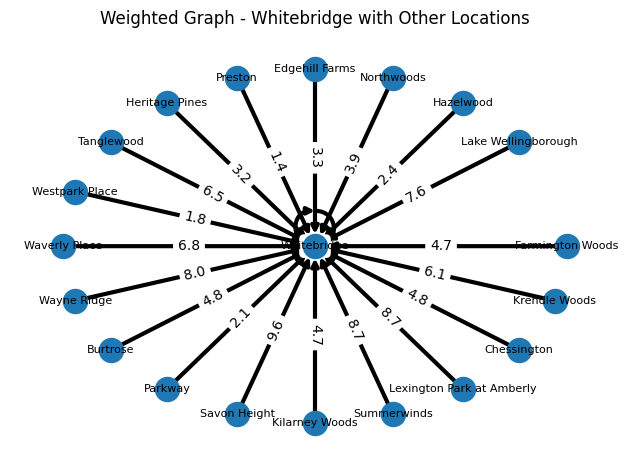

In [ ]:
# Create a new graph
G_whitebridge = nx.DiGraph()

# Iterate over the data rows
for _, row in data.iterrows():
    start = row['START*']
    stop = row['STOP*']
    miles = row['MILES*']
    
    if stop == 'Whitebridge':  # Only consider edges with Whitebridge as the stop location
        G_whitebridge.add_edge(start, stop, weight=miles)

# Define the positions of the nodes using a circular layout
pos_whitebridge = nx.circular_layout(G_whitebridge)

# Set the position of Whitebridge node to (0, 0)
pos_whitebridge['Whitebridge'] = (0, 0)

# Draw the nodes and edges
nx.draw_networkx_nodes(G_whitebridge, pos_whitebridge, node_size=300)
nx.draw_networkx_edges(G_whitebridge, pos_whitebridge, width=3)

# Draw labels for nodes
nx.draw_networkx_labels(G_whitebridge, pos_whitebridge, font_size=8)

# Draw edge weight labels
edge_labels_whitebridge = nx.get_edge_attributes(G_whitebridge, "weight")
nx.draw_networkx_edge_labels(G_whitebridge, pos_whitebridge, edge_labels_whitebridge)

# Set the title
plt.title('Weighted Graph - Whitebridge with Other Locations')

# Display the graph
plt.axis("off")
plt.tight_layout()
plt.show()

##Hipoteza 2: Postoji razlika u vremenu putovanja između lokacija po milji.

In [ ]:
import datetime

# Convert the start and end times to datetime objects
data['Start_Time'] = pd.to_datetime(data['Start_Time'], format='%H:%M')
data['End_Time'] = pd.to_datetime(data['End_Time'], format='%H:%M')

# Calculate the travel time in minutes
data['Travel_Time'] = (data['End_Time'] - data['Start_Time']).dt.total_seconds() / 60

# Convert the travel time to integer
data['Travel_Time'] = data['Travel_Time'].astype(int)


Sljedeća vizualizacija prikazuje težinski usmjereni graf sa Whitebridge-om u središtu, pri čemu težine predstavljaju vrijeme putovanja u minutama između pojedine lokacije i Whitebridge-a.

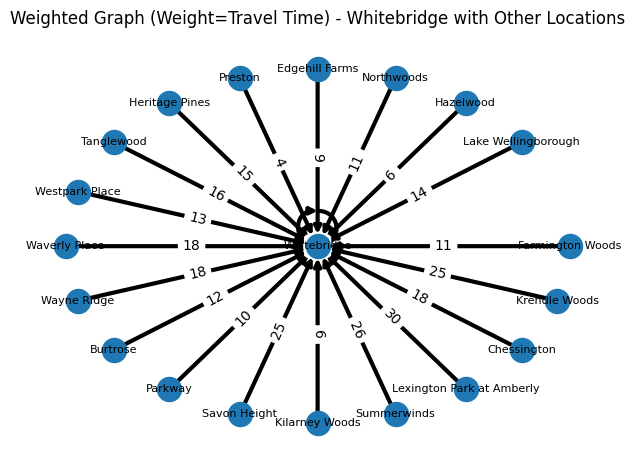

In [ ]:
# Create a new graph
G_whitebridge = nx.DiGraph()

# Iterate over the data rows
for _, row in data.iterrows():
    start = row['START*']
    stop = row['STOP*']
    travel_time = row['Travel_Time']
    
    if stop == 'Whitebridge':  # Only consider edges with Whitebridge as the stop location
        G_whitebridge.add_edge(start, stop, weight=travel_time)

# Define the positions of the nodes using a circular layout
pos_whitebridge = nx.circular_layout(G_whitebridge)

# Set the position of Whitebridge node to (0, 0)
pos_whitebridge['Whitebridge'] = (0, 0)

# Draw the nodes and edges
nx.draw_networkx_nodes(G_whitebridge, pos_whitebridge, node_size=300)
nx.draw_networkx_edges(G_whitebridge, pos_whitebridge, width=3)

# Draw labels for nodes
nx.draw_networkx_labels(G_whitebridge, pos_whitebridge, font_size=8)

# Draw edge weight labels
edge_labels_whitebridge = nx.get_edge_attributes(G_whitebridge, "weight")
nx.draw_networkx_edge_labels(G_whitebridge, pos_whitebridge, edge_labels_whitebridge)

# Set the title
plt.title('Weighted Graph (Weight=Travel Time) - Whitebridge with Other Locations')

# Display the graph
plt.axis("off")
plt.tight_layout()
plt.show()

Obzirom da pokušavam dokazati kako postoji razlika u vremenu putovanja po milji između pojedinih lokacija, sljedeći graf prikazuje težinski usmjereni graf pri čemu su težine omjeri milja i vremena putovanja.

In [ ]:
dataframe = data 

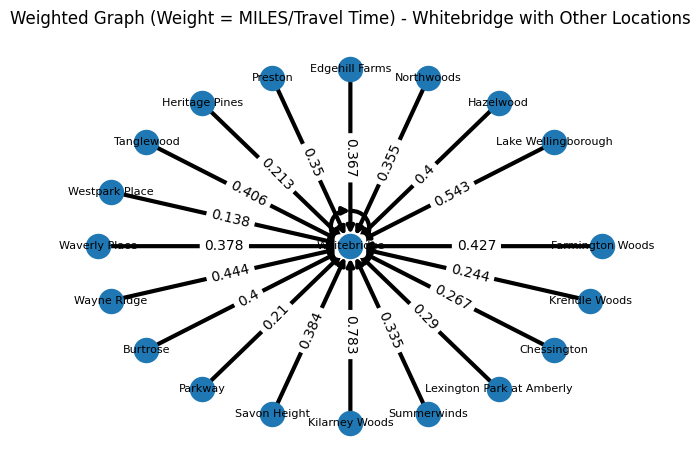

In [ ]:
data =dataframe

# Create a new graph for the Whitebridge subgraph
G_whitebridge = nx.DiGraph()

# Iterate over the data rows
for _, row in data.iterrows():
    start = row['START*']
    stop = row['STOP*']
    miles = row['MILES*']
    travel_time = row['Travel_Time']
    
    if stop == 'Whitebridge':  # Only consider edges with Whitebridge as the stop location
        G_whitebridge.add_edge(start, stop, weight=miles, travel_time=travel_time)

# Calculate the ratio of miles to travel time for each edge in the Whitebridge subgraph
ratio_dict = {}
for u, v, data in G_whitebridge.edges(data=True):
    miles = data['weight']
    travel_time = data['travel_time']
    ratio = np.round((miles / travel_time),3)
    ratio_dict[(u, v)] = ratio

# Add the ratio as an edge attribute to the Whitebridge subgraph
nx.set_edge_attributes(G_whitebridge, ratio_dict, 'ratio')

# Define the positions of the nodes using a spring layout
pos_whitebridge = nx.circular_layout(G_whitebridge)

# Set the position of Whitebridge node to (0, 0)
pos_whitebridge['Whitebridge'] = (0, 0)

# Draw the nodes and edges
nx.draw_networkx_nodes(G_whitebridge, pos_whitebridge, node_size=300)
nx.draw_networkx_edges(G_whitebridge, pos_whitebridge, width=3)

# Draw labels for nodes
nx.draw_networkx_labels(G_whitebridge, pos_whitebridge, font_size=8)

# Draw edge weight labels
edge_labels_whitebridge = nx.get_edge_attributes(G_whitebridge, "ratio")
nx.draw_networkx_edge_labels(G_whitebridge, pos_whitebridge, edge_labels_whitebridge)

# Set the title
plt.title('Weighted Graph (Weight = MILES/Travel Time) - Whitebridge with Other Locations')

# Display the graph
plt.axis("off")
plt.tight_layout()
plt.show()

# u funkciji prije se događa override dataframea
data = dataframe

Iz grafa možemo potvrditi hipotezu 2, odnosno možemo zaključiti kako postoji razlika u vremenu putovanja između lokacija po milji.
> Veći broj predstavlja brže putovanje: npr. Kilarney Woods - Whitebridge možemo smatrati dionicom koja nije prometno zagušena ili je u pitanju autocesta.

> Manji broj predstavlja sporije putovanje: npr. Westpark Place - Whitebridge možemo smatrati prometnom dionicom, dionicom grad-predgrađe i slično gdje su moguća prometna zagušenja ili radovi na cesti pa je i putovanje sporije.


##Hipoteza 3: Poslovna putovanja imaju veće udaljenosti u usporedbi s osobnim putovanjima.

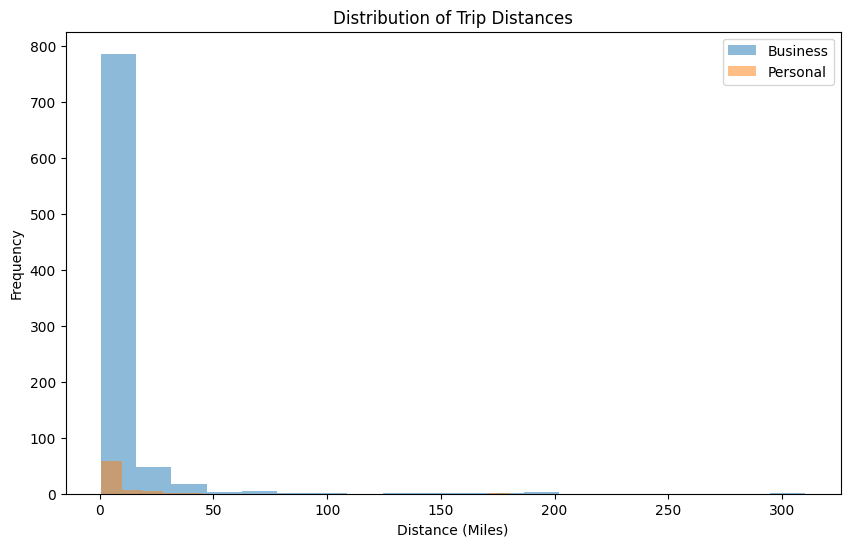

In [ ]:
business_trips = data[data['CATEGORY*'] == 'Business']
personal_trips = data[data['CATEGORY*'] == 'Personal']

#G = nx.from_pandas_edgelist(df, source='START*', target='STOP*', edge_attr='MILES*', create_using=nx.DiGraph())

plt.figure(figsize=(10, 6))
plt.hist(business_trips['MILES*'], bins=20, alpha=0.5, label='Business')
plt.hist(personal_trips['MILES*'], bins=20, alpha=0.5, label='Personal')
plt.xlabel('Distance (Miles)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Distances')
plt.legend()
plt.show()

In [ ]:
business_mean = business_trips['MILES*'].mean()
personal_mean = personal_trips['MILES*'].mean()

business_mean,personal_mean

(9.9654420206659, 9.187671232876712)

Iz histograma teško možemo zaključiti možemo li potvrditi hipotezu 1 ili ne, jer je većina udaljenosti na lijevom dijelu grafa uz iznimke outliera iznad 50 milja. 
No, kada pogledam srednju vrijednost za poslovne i osobne svrhe zaključujem kako možemo potvrditi hipotezu 1, ali valja naglasiti kako se prosječne vrijednosti ne razlikuju previše.

##Hipoteza 4: Putovanja sa svrhom "Meeting" imaju veću prosječnu udaljenost od putovanja s drugim svrhama.

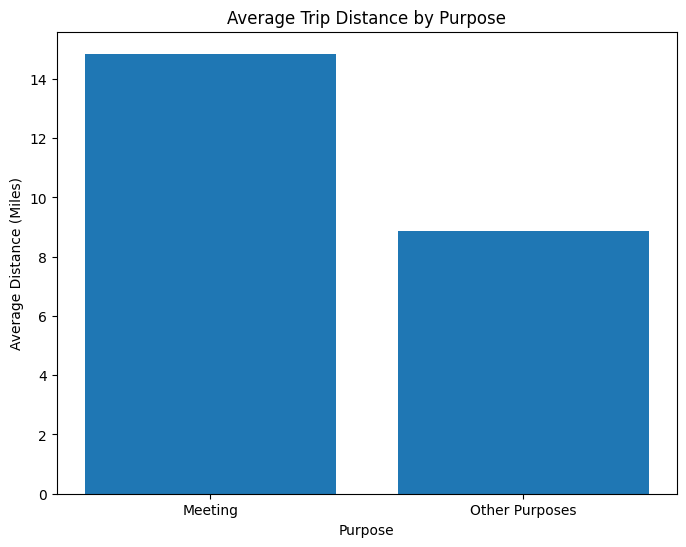

In [ ]:
meeting_trips = data[data['PURPOSE*'] == 'Meeting']
other_purpose_trips = data[data['PURPOSE*'] != 'Meeting']

meeting_avg_distance = meeting_trips['MILES*'].mean()
other_purpose_avg_distance = other_purpose_trips['MILES*'].mean()

plt.figure(figsize=(8, 6))
plt.bar(['Meeting', 'Other Purposes'], [meeting_avg_distance, other_purpose_avg_distance])
plt.xlabel('Purpose')
plt.ylabel('Average Distance (Miles)')
plt.title('Average Trip Distance by Purpose')
plt.show()

Prihvaćamo hipotezu jer vidimo da su udaljenosti veće ukoliko je u pitanju 'Meeting' putovanje.

##Hipoteza 5: Postoji razlog zbog kojega su baš određene lokacije slabije posjećene.

### Miles/Travel Time

In [ ]:
def draw_miles_time_travel_ratio(city, data):
  dataframe = data
  # Create a new graph for the Whitebridge subgraph
  G = nx.DiGraph()

  # Iterate over the data rows
  for _, row in data.iterrows():
      start = row['START*']
      stop = row['STOP*']
      miles = row['MILES*']
      travel_time = row['Travel_Time']
      
      if stop == city:  # Only consider edges with Whitebridge as the stop location
          G.add_edge(start, stop, weight=miles, travel_time=travel_time)

  # Calculate the ratio of miles to travel time for each edge in the Whitebridge subgraph
  ratio_dict = {}
  for u, v, data in G.edges(data=True):
      miles = data['weight']
      travel_time = data['travel_time']
      ratio = np.round((miles / travel_time),3)
      ratio_dict[(u, v)] = ratio

  # Add the ratio as an edge attribute to the Whitebridge subgraph
  nx.set_edge_attributes(G, ratio_dict, 'ratio')

  # Define the positions of the nodes using a spring layout
  pos_whitebridge = nx.circular_layout(G)

  # Set the position of Whitebridge node to (0, 0)
  pos_whitebridge[city] = (0, 0)

  # Draw the nodes and edges
  nx.draw_networkx_nodes(G, pos_whitebridge, node_size=300)
  nx.draw_networkx_edges(G, pos_whitebridge, width=3)

  # Draw labels for nodes
  nx.draw_networkx_labels(G, pos_whitebridge, font_size=8)

  # Draw edge weight labels
  edge_labels_whitebridge = nx.get_edge_attributes(G, "ratio")
  nx.draw_networkx_edge_labels(G, pos_whitebridge, edge_labels_whitebridge)

  # Set the title
  plt.title(f'Weighted Graph (Weight = MILES/Travel Time) - {city} with Other Locations')

  # Display the graph
  plt.axis("off")
  plt.tight_layout()
  plt.show()

  # u funkciji prije se događa override dataframea
  data = dataframe

In [ ]:
# Find nodes with in-degree between 5 and 6
nodes_with_in_degree_5_to_6 = [node for node, in_degree in G.in_degree() if 5 <= in_degree <= 6]

# Print nodes with in-degree between 5 and 6
print("Nodes with in-degree between 5 and 6:")
for node in nodes_with_in_degree_5_to_6:
    in_degree = G.in_degree()[node]
    print(f"Node: {node}, In-Degree: {in_degree}")

Nodes with in-degree between 5 and 6:
Node: Morrisville, In-Degree: 6
Node: Central, In-Degree: 5


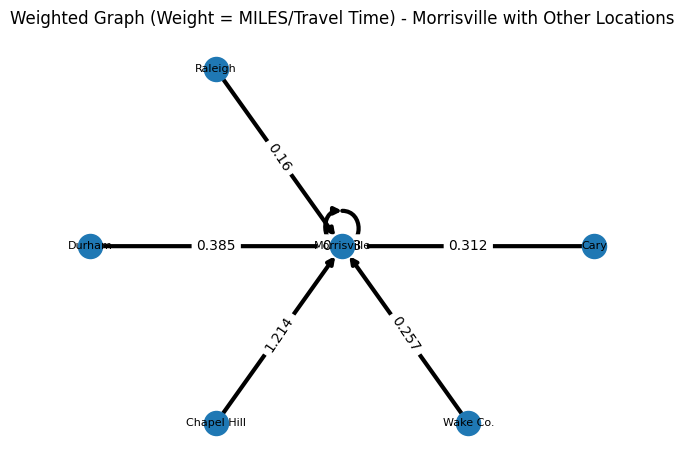

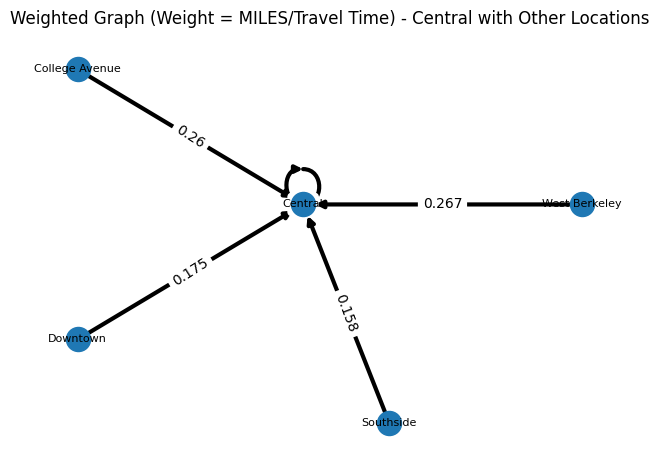

(None, None)

In [ ]:
draw_miles_time_travel_ratio("Morrisville", data), draw_miles_time_travel_ratio("Central", data)

Iz grafikona vidimo kako su omjeri Miles/Travel Time maleni, što bi značilo da se do lokacija 'Morrisville' i 'Central' duže putuje (osim u iznimnom slučaju Chapel Hill-Morrisville) što bi mogao biti razlog zašto su te lokacije slabije posjećene pa potvrđujemo hipotezu 5.

>Napomena: uzeti su baš ovi čvorovi, jer je čvorova sa manjim stupnjem bilo više pa bi ih bilo teže analizirati.

### Miles

In [ ]:
def draw_distance(city, data): 
  # Create a new graph
  G = nx.DiGraph()

  # Iterate over the data rows
  for _, row in data.iterrows():
      start = row['START*']
      stop = row['STOP*']
      miles = row['MILES*']
      
      if stop == city:  # Only consider edges with Whitebridge as the stop location
          G.add_edge(start, stop, weight=miles)

  # Define the positions of the nodes using a circular layout
  pos = nx.circular_layout(G)

  # Set the position of Whitebridge node to (0, 0)
  pos[city] = (0, 0)

  # Draw the nodes and edges
  nx.draw_networkx_nodes(G, pos, node_size=300)
  nx.draw_networkx_edges(G, pos, width=3)

  # Draw labels for nodes
  nx.draw_networkx_labels(G, pos, font_size=8)

  # Draw edge weight labels
  edge_labels = nx.get_edge_attributes(G, "weight")
  nx.draw_networkx_edge_labels(G, pos, edge_labels)

  # Set the title
  plt.title(f'Weighted Graph (Weight=Miles) - {city} with Other Locations')

  # Display the graph
  plt.axis("off")
  plt.tight_layout()
  plt.show()

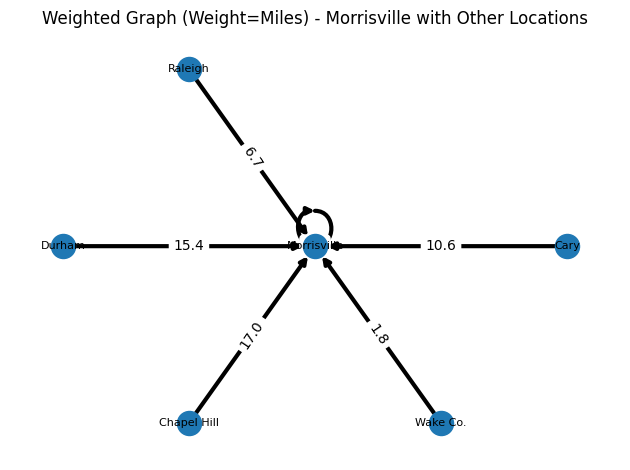

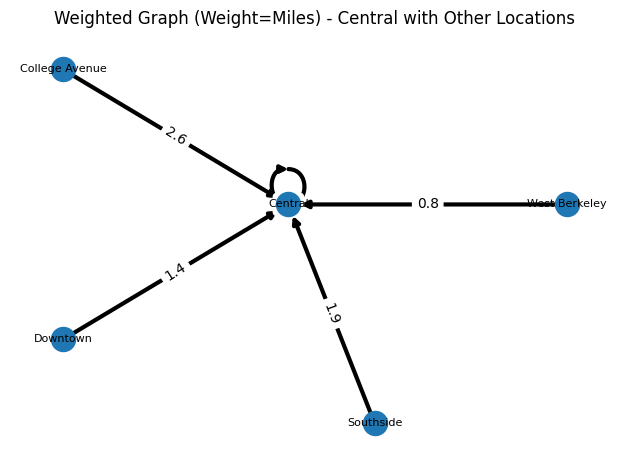

(None, None)

In [ ]:
draw_distance('Morrisville', data), draw_distance('Central', data)

Iz grafova vidimo kako bi potencijalni problem mogla biti i udaljenost između lokacija pa se zbog toga slabije putuje, što je slučaj za Morrisville.

## Hipoteza 6: Određene svrhe putovanja ističu se za pojedini čvor.



<ipython-input-66-8a047f52e703>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(travel_categories))


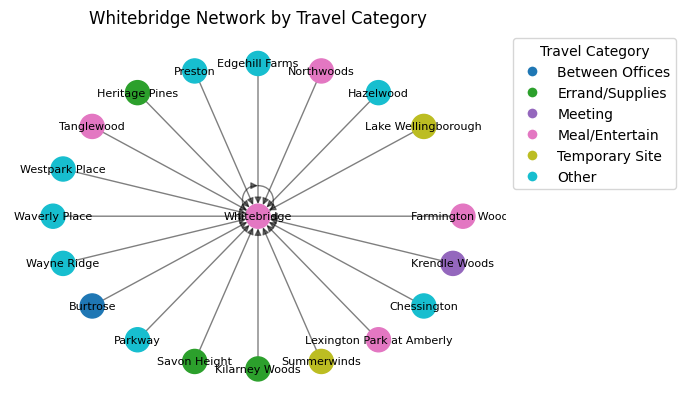

In [ ]:
# Create a directed graph for Whitebridge
G_whitebridge = nx.DiGraph()

# Iterate over the data rows
for _, row in data.iterrows():
    start = row['START*']
    stop = row['STOP*']
    travel_category = row['PURPOSE*']
    
    if stop == 'Whitebridge':
        # Add edges to the Whitebridge graph
        G_whitebridge.add_edge(start, stop, travel_category=travel_category)

# Compute the adjacency matrix for Whitebridge
adj_matrix_whitebridge = nx.to_numpy_array(G_whitebridge)

# Get unique travel categories
travel_categories = set(nx.get_edge_attributes(G_whitebridge, 'travel_category').values())

# Assign colors to each travel category
colors = plt.cm.get_cmap('tab10', len(travel_categories))

# Create a dictionary to map each category to a color
category_color_map = {category: colors(i) for i, category in enumerate(travel_categories)}

# Extract the colors for the nodes based on the travel category
node_colors = [category_color_map[data['travel_category']] for _, _, data in G_whitebridge.edges(data=True)]

# Create the plot
fig, ax = plt.subplots()

# Draw the nodes and edges
nx.draw_networkx_nodes(G_whitebridge, pos_whitebridge, node_color=node_colors, node_size=300)
nx.draw_networkx_edges(G_whitebridge, pos_whitebridge, width=1.0, alpha=0.5)

# Draw the labels
nx.draw_networkx_labels(G_whitebridge, pos_whitebridge, font_size=8)

# Set the axis properties
plt.axis('off')
plt.title('Whitebridge Network by Travel Category')

# Create the legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors(i), markersize=8, label=category) for i, category in enumerate(travel_categories)]
legend = ax.legend(handles=legend_elements, title='Travel Category', bbox_to_anchor=(1, 1), loc='upper left')

# Move the legend to the desired location
legend.set_bbox_to_anchor((1, 1))

# Show the plot
plt.show()

Ukoliko izuzmemo svrhu 'Other', vidimo kako je svrha putovanja u Whitebridge nabavka namjernica (Errand/Supplies) i zabava (Meal/Enertain) po čemu možemo potvrditi hipotezu 6 i zaključiti kako se u Whitebridgeu nalaze dućani, restorani i slično.

#Zaključak

- Analiza potvrđuje prisutnost glavnog čvorišta, 'Whitebridgea' u putničkoj mreži. 
- Primjećuju se razlike u vremenu putovanja po milji, pri čemu neke dionice ukazuju na brža putovanja, a druge sugeriraju sporija putovanja potencijalno zbog zagušenja ili radova na cesti. 
-Poslovna putovanja obično imaju nešto veće udaljenosti u usporedbi s osobnim putovanjima. 
- Putovanja sa svrhom "sastanka" imaju veću prosječnu udaljenost od ostalih svrha. 
- Manje posjećene lokacije kao što su "Morrisville" i "Central" imaju dulje vrijeme putovanja i niži omjer milja/vrijeme putovanja. 
- Svrha putovanja u 'Whitebridge' prvenstveno uključuje poslove i zabavu, ističući specifične svrhe putovanja za ovaj čvor. 

Ovi razmatranja poboljšavaju naše razumijevanje obrazaca putovanja korisnika Ubera, čimbenika ponašanja i karakteristika čvorova, što pomaže u razumijevanju dinamike prijevoza i identificiranju potencijalnih poboljšanja.